<a href="https://colab.research.google.com/github/shcjsaud3613/predict_img_with_CNN/blob/main/food_classifier_total.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InceptionV3를 활용한 음식 이미지 분류

이 파일은 keras, tensorflow, InceptionV3를 활용한 음식 이미지를 학습하고 분류하는 모델을 만드는 과정을 다룬다.

## Google Colab 링크

https://colab.research.google.com/drive/1wl67VtQbxdfLNo2Z8ItxADs_SHzOugrU#scrollTo=OYjmXH1EbAvI

**Food Dataset** - https://www.vision.ee.ethz.ch/datasets_extra/food-101/

**일부 학습 데이터세트는 AI Hub에서 신청하여 받았고, 저작자는 한국지능정보사회진흥원이다.**

## 참고자료

https://colab.research.google.com/drive/1bO5c3wT9M84H-Y2a7saaBArPXF6ii4v8#scrollTo=7wJ_OH1DQyrd

In [ ]:
# Google Colab 재시작
!kill -9 -1

## 데이터세트 다운로드

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [2]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.4.1
/device:GPU:0


- 데이터를 다운로드한다.

In [ ]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

# Download data and extract it to folder
get_data_extract()

4996284416/4996278331 [==============================] - 74s 0us/step
Dataset downloaded and extracted!


## 데이터세트 구성 확인

다운받은 데이터세트의 디렉토리 구성을 확인한다.

In [ ]:
# Check the extracted dataset folder
os.listdir('food-101/')

['README.txt', 'license_agreement.txt', 'meta', 'images']

In [ ]:
os.listdir('food-101/images')

In [ ]:
os.listdir('food-101/meta')

['train.txt',
 'test.txt',
 'classes.txt',
 'test.json',
 'train.json',
 'labels.txt']

## 랜덤 이미지 시각화

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

## 이미지를 훈련용과 테스트용으로 분류

In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

meta 폴더 안에 있는 `train.txt`, `test.txt` 를 참고하여 데이터세트를 분류한다.

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

폴더에 분류가 잘 되었는지 개수를 확인한다.

In [ ]:
# Check how many files are in the train folder
train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


# 분류되어 있는 훈련 및 학습데이터 다운로드

**food-101**에는 양식 데이터, **한국지능정보사회진흥원**에서는 한식 데이터가 포함되어 있다.

한국 국민이 자주 먹는 음식을 위주로 골라 훈련용, 테스트용으로 분류했다.

## 한글 폰트 다운로드

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

## 구글 드라이브 마운트

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터세트 다운로드

In [ ]:
!unzip /content/drive/MyDrive/Colab/yumyum-project/food.zip

## 데이터세트 구성 확인

In [ ]:
os.listdir('food/train')

## 랜덤 이미지 시각화

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food/train/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

# 3가지 음식 이미지 분류 모델

이 챕터에서는 사모사, 피자, 오믈렛을 분류하는 모델을 훈련한다.

전체적인 코드가 잘 작동하는지 확인하기 위함이기에, 사전에 문제가 없다고 검증이 끝났다면 바로 다음 챕터로 넘어가도 된다.

## 3가지 음식이 포함된 학습 및 테스트 데이터세트 만들기

In [ ]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

In [8]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

선정된 음식파일은 각각 `train_mini`, `test_mini` 에 저장한다.

In [9]:
# picking 3 food items and generating separate data folders for the same
# root_dir = 'food-101'
root_dit = 'food'
food_list = ['후라이드치킨','피자','볶음밥']
src_train = root_dit+'/train'
dest_train = root_dit+'/train_mini'
src_test = root_dit+'/test'
dest_test = root_dit+'/test_mini'

데이터세트를 저장하고 개수를 확인한다.

In [10]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into 후라이드치킨
Copying images into 피자
Copying images into 볶음밥


In [11]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food/train_mini")])
print(train_files)

Total number of samples in train folder
2250


In [12]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into 후라이드치킨
Copying images into 피자
Copying images into 볶음밥


In [13]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food/test_mini")])
print(test_files)

Total number of samples in test folder
750


## 분류한 데이터세트로 Inception 모델 미세조정

In [15]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'food/train_mini'
  validation_data_dir = 'food/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [16]:
# Train the model with data from 3 classes
n_classes = 3
epochs = 5
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87916544/87910968 [==============================] - 0s 0us/step
Epoch 1/5
 22/140 [===>..........................] - ETA: 42s - loss: 1.2250 - accuracy: 0.2838

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


140/140 [==============================] - 92s 395ms/step - loss: 1.1041 - accuracy: 0.4258 - val_loss: 0.6041 - val_accuracy: 0.9035

Epoch 00001: val_loss improved from inf to 0.60415, saving model to bestmodel_3class.hdf5
Epoch 2/5
140/140 [==============================] - 53s 380ms/step - loss: 0.6645 - accuracy: 0.8239 - val_loss: 0.3498 - val_accuracy: 0.9457

Epoch 00002: val_loss improved from 0.60415 to 0.34984, saving model to bestmodel_3class.hdf5
Epoch 3/5
140/140 [==============================] - 53s 378ms/step - loss: 0.4270 - accuracy: 0.8947 - val_loss: 0.2369 - val_accuracy: 0.9660

Epoch 00003: val_loss improved from 0.34984 to 0.23687, saving model to bestmodel_3class.hdf5
Epoch 4/5
140/140 [==============================] - 53s 378ms/step - loss: 0.3122 - accuracy: 0.9220 - val_loss: 0.1771 - val_accuracy: 0.9755

Epoch 00004: val_loss improved from 0.23687 to 0.17708, saving model to bestmodel_3class.hdf5
Epoch 5/5
140/140 [==============================] - 53s 3

## 정확도(accuracy)와 손실값(loss)를 시각화한다.

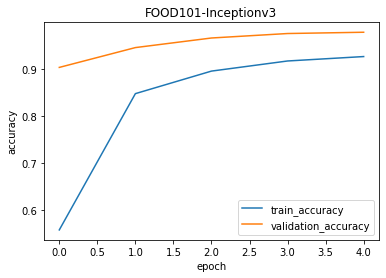

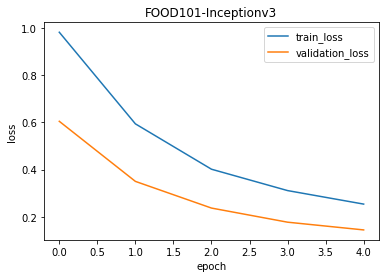

In [23]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

## 훈련된 모델로 음식 이미지를 예측

In [24]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_3class.hdf5',compile = False)

CPU times: user 1.72 s, sys: 77.6 ms, total: 1.8 s
Wall time: 1.78 s


In [25]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Make a list of images and test the trained model
images = []
images.append('/content/food/test_mini/피자/11297.jpg')
images.append('/content/food/test_mini/후라이드치킨/Img_028_0759.jpg')
images.append('/content/food/test_mini/볶음밥/1106712.jpg')
predict_class(model_best, images, True)

# 전체 음식 이미지 분류 모델

이 챕터에서는 `food-101` 리스트에 있는 모든 음식 이미지를 분류하는 모델을 훈련한다.

이전 챕터에서 이미 훈련용, 테스트용으로 분류했기 때문에 데이터세트 분류 작업은 넘어간다.

## 분류한 데이터세트로 Inception 모델 미세조정

먼저 전체 데이터세트 내용을 다시 확인한다.

In [27]:
# root_dir = 'food-101'
root_dir = 'food'

In [28]:
foods_sorted = sorted(os.listdir(root_dir+'/train'))
print(foods_sorted)
print(len(foods_sorted))

['간장게장', '갈비구이', '갈비찜', '갈비탕', '감자탕', '감자튀김', '고등어구이', '곱창구이', '교자', '그라탕', '김치찌개', '김치찜', '까르보나라', '닭갈비', '닭계장', '닭볶음탕', '도넛', '된장찌개', '떡볶이', '라멘', '라면', '라자냐', '만두', '매운탕', '물냉면', '물회', '미소된장국', '보쌈', '볶음밥', '봉골레파스타', '불고기', '비빔냉면', '비빔밥', '삼겹살', '삼계탕', '새우튀김', '샌드위치', '설렁탕', '수육', '수제비', '순대', '순두부찌개', '스테이크', '양념게장', '양념치킨', '연어구이', '연어회', '오믈렛', '오징어튀김', '와플', '육개장', '육회', '잔치국수', '전골', '전복죽', '제육볶음', '조개구이', '족발', '주꾸미볶음', '짜장면', '짬뽕', '쫄면', '찜닭', '초밥', '추어탕', '카레', '칼국수', '콩국수', '타코야끼', '토스트', '파전', '팬케이크', '피자', '핫도그', '해물찜', '햄버거', '후라이드치킨', '훈제오리']
78


In [29]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk(root_dir+"/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
58500


In [30]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk(root_dir+"/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
19500


다음 적절한 학습함수를 설정하고 모델을 훈련한다.

필자는 `batch_size` 를 16, `epochs` 를 20으로 설정했다.

In [32]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = root_dir+'/train'
  validation_data_dir = root_dir+'/test'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
# Train the model with data from all(101) classes
n_classes = len(foods_sorted)
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map)

Found 58500 images belonging to 78 classes.
Found 19500 images belonging to 78 classes.
Epoch 1/20
 119/3656 [..............................] - ETA: 23:37 - loss: 4.9170 - accuracy: 0.0114

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


2037/3656 [===============>..............] - ETA: 10:28 - loss: 4.7967 - accuracy: 0.0289

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


3211/3656 [=========================>....] - ETA: 2:51 - loss: 4.7105 - accuracy: 0.0477

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1078 bytes but only got 0. Skipping tag 37500
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 125 bytes but only got 120. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


3656/3656 [==============================] - 1564s 426ms/step - loss: 4.6728 - accuracy: 0.0556 - val_loss: 3.2417 - val_accuracy: 0.3980

Epoch 00001: val_loss improved from inf to 3.24166, saving model to bestmodel_78class.hdf5
Epoch 2/20
3656/3656 [==============================] - 1553s 425ms/step - loss: 3.2414 - accuracy: 0.3253 - val_loss: 2.0128 - val_accuracy: 0.6101

Epoch 00002: val_loss improved from 3.24166 to 2.01279, saving model to bestmodel_78class.hdf5
Epoch 3/20
3656/3656 [==============================] - 1538s 421ms/step - loss: 2.3827 - accuracy: 0.5027 - val_loss: 1.6106 - val_accuracy: 0.6866

Epoch 00003: val_loss improved from 2.01279 to 1.61060, saving model to bestmodel_78class.hdf5
Epoch 4/20
3656/3656 [==============================] - 1546s 423ms/step - loss: 1.9997 - accuracy: 0.5849 - val_loss: 1.4106 - val_accuracy: 0.7231

Epoch 00004: val_loss improved from 1.61060 to 1.41056, saving model to bestmodel_78class.hdf5
Epoch 5/20
3656/3656 [=============

## 정확도(accuracy)와 손실값(loss)를 시각화한다.

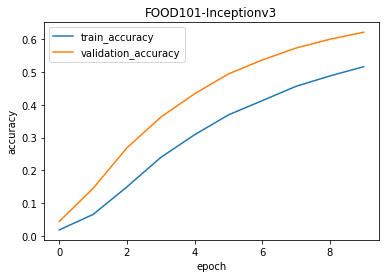

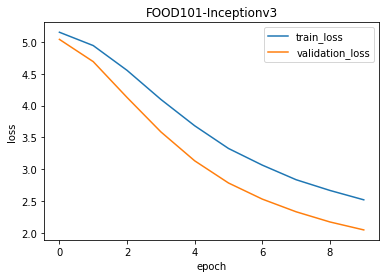

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

## 훈련된 모델로 음식 이미지를 예측

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_101class.hdf5',compile = False)

CPU times: user 1.9 s, sys: 71.8 ms, total: 1.97 s
Wall time: 2.06 s


### 단일 이미지 예측

In [ ]:
def predict_class_single(model, img, show = True):
  img = image.load_img(img, target_size=(299, 299))
  img = image.img_to_array(img)                    
  img = np.expand_dims(img, axis=0)         
  img = preprocess_input(img)                                      

  pred = model.predict(img)
  index = np.argmax(pred)
  pred_value = foods_sorted[index]
  #print(pred)
  if show:
      plt.imshow(img[0])                           
      plt.axis('off')
      plt.title(pred_value)
      plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


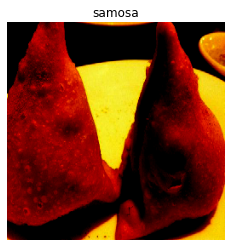

In [ ]:
# imagepath = '/content/food-101/test/samosa/144404.jpg'
imagepath = '/content/food-101/test/lasagna/1338545.jpg'
predict_class_single(model_best, imagepath, True)

### 멀티 이미지 예측

In [ ]:
def predict_class_multi(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    pred_value = foods_sorted[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Make a list of images and test the trained model
images = []
imagepath = '/content/food-101/test/'
images.append(imagepath+'samosa/144404.jpg')
images.append(imagepath+'pizza/11297.jpg')
images.append(imagepath+'omelette/1145379.jpg')
predict_class_multi(model_best, images, True)

# 모델 다운로드

먼저 하위 폴더 목록을 확인한다.

In [ ]:
ls

bestmodel_101class.hdf5  food-101.tar.gz  sample_data/
bestmodel_3class.hdf5    history_101.log  trainedmodel_101class.hdf5
food-101/                history_3.log    trainedmodel_3class.hdf5


다운로드 할 파일 경로를 입력한다.

In [ ]:
from google.colab import files

files.download('/content/bestmodel_101class.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>